In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from data_loader import PybulletNpyDataset, TabletopTemplateDataset

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet50

# Template-data

In [3]:
resnet = resnet18
model_path = 'data/classification-best/top_nobg_linspace_mse-best.pth'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/train'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-seen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-seen_obj-unseen_template'
data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template'
device = "cuda:0"

dataset = TabletopTemplateDataset(data_dir=data_path, 
            remove_bg=True, label_type='linspace', view='top')
dataset.fsize = 200
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=1)

model = resnet(pretrained=False)
fc_in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_in_features, 1),
    #nn.Sigmoid()
)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
def scoring(model, dataloader):
    scores = {}
    for s in [0, 0.25, 0.5, 0.75, 1]:
        scores[s] = []

    for X_val, Y_val in dataloader:
        x_raw = X_val.cpu().numpy().transpose([0, 2, 3, 1])
        X_val = preprocess(X_val).to(device)
        y_val = Y_val[:, 0].to(device)
        y_pred = model(X_val)[:, 0].detach().cpu().numpy()

        for s in [0, 0.25, 0.5, 0.75, 1]:
            scores[s] += y_pred[Y_val[:, 0]==s].tolist()
    return scores

In [7]:
scores = scoring(model, dataloader)

In [68]:
for s in [0, 0.25, 0.5, 0.75, 1]:
    print(f'label: {s} / mean: {np.mean(scores[s])} / std: {np.std(scores[s])})')


label: 0 / mean: 0.2089111018246865 / std: 0.17449404720122255)
label: 0.25 / mean: 0.283584279886718 / std: 0.1856526061416466)
label: 0.5 / mean: 0.398526309090136 / std: 0.18835782131092674)
label: 0.75 / mean: 0.5705491407111853 / std: 0.15001914015593187)
label: 1 / mean: 0.8677036750618415 / std: 0.09836765247127696)


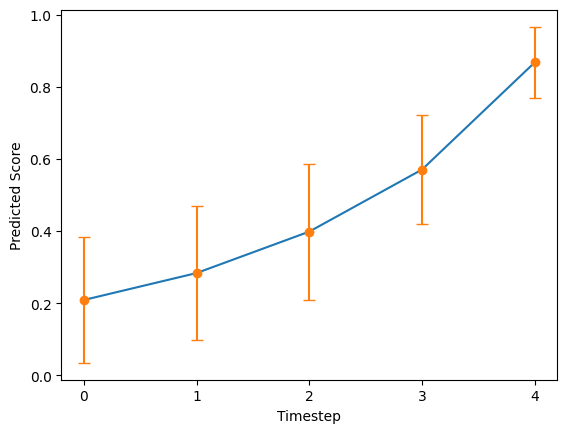

In [83]:
labels = np.array([0, 0.25, 0.5, 0.75, 1])
mean = [np.mean(scores[s]) for s in labels]
error = [np.std(scores[s]) for s in labels]

plt.plot(np.array(labels)*4, mean)
plt.errorbar(np.array(labels)*4, mean, error, fmt='o', capsize=4)
plt.xlabel("Timestep")
plt.ylabel("Predicted Score")
plt.xticks([0, 1, 2, 3, 4])
plt.show()


In [58]:
scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

thresholds = np.linspace(0.5, 1, 21)
recalls = []
precisions = []

for th in thresholds:
    recall = np.array(scores[1]>th).sum() / len(scores[1])
    recalls.append(recall)
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    precisions.append(precision)

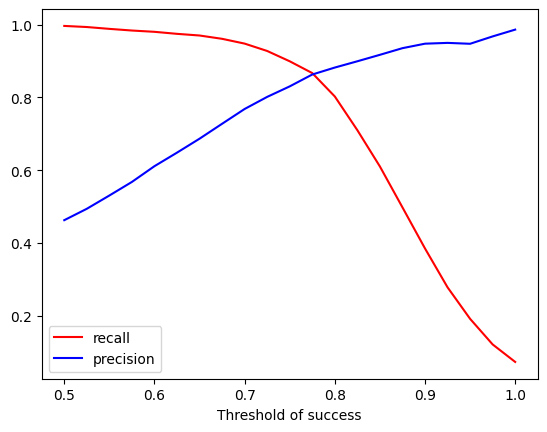

In [62]:
plt.plot(thresholds, recalls, 'r-', label='recall')
plt.plot(thresholds, precisions, 'b-', label='precision')
plt.xlabel("Threshold of success")
#plt.ylabel("Metrics")
plt.legend()
plt.show()

In [93]:
scores_all = np.concatenate([scores[s] for s in [0, 0.25, 0.5, 0.75, 1]])
labels = np.concatenate([[s]*len(scores[s]) for s in [0, 0.25, 0.5, 0.75, 1]])

for th in np.linspace(0.6, 1, 9):
    recall = np.array(scores[1]>th).sum() / len(scores[1])
    precision = (labels[scores_all > th]==1).sum() / (scores_all > th).sum()
    print(f'threshold: {th:.2f} / recall: {recall:.3f} / precision: {precision:.3f}')

threshold: 0.60 / recall: 0.980 / precision: 0.611
threshold: 0.65 / recall: 0.970 / precision: 0.686
threshold: 0.70 / recall: 0.948 / precision: 0.768
threshold: 0.75 / recall: 0.899 / precision: 0.830
threshold: 0.80 / recall: 0.803 / precision: 0.882
threshold: 0.85 / recall: 0.610 / precision: 0.917
threshold: 0.90 / recall: 0.385 / precision: 0.948
threshold: 0.95 / recall: 0.191 / precision: 0.947
threshold: 1.00 / recall: 0.073 / precision: 0.986
